link to data: https://drive.google.com/file/d/14FdevY2Gxdyt2eI8amPYP_I3aTmIu5l1/view?usp=sharing

# 0. Imports


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models  import Sequential
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras import callbacks
import pickle

In [ ]:
!pip install split_folders

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import zipfile
import os
import enum

import splitfolders

## 0.1 Mounting Drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# data zip
!ls gdrive/MyDrive/ENEL645/

Data  modules  Notebooks


In [ ]:
# unzip data and add to /temp dir
zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/ENEL645/Data/Data.zip', 'r')
zip_ref.extractall('/temp')
zip_ref.close()

In [ ]:
# sub directories in data zip
print(os.listdir('/temp/Data/'))

['.DS_Store', 'Full', 'ProfsData', 'Prof_Kaggle', 'OurData', 'KaggleData']


In [ ]:
our_data_path = '/temp/Data/OurData'
full_data_path = '/temp/Data/Full'
kaggle_data_path = '/temp/Data/KaggleData'
prof_kaggle_data_path = '/temp/Data/Prof_Kaggle'
enel_data_path = '/temp/Data/ProfsData'

path = '/train_val_test'

In [ ]:
import shutil
#shutil.rmtree('/temp/Data/ProfsData/train_val_test')

## 0.2 Functions

In [ ]:
# function to train test split data in data_path to output_name directories
def train_val_test_split(data_path, output_name, train_per, test_per, val_per):
  splitfolders.ratio(data_path, output=output_name,
    seed=123, ratio=(train_per, test_per, val_per), group_prefix=None, move=False)

In [ ]:
# function to count files in specified directory
def count_files(item_dir):
  return len(os.listdir(item_dir))

In [ ]:
# deletes files from specified directory
def delete_files(path):
  import shutil
  shutil.rmtree(path)

In [ ]:
#delete_files('/checkpoints/vgg16')

# Part 0: Models

In [ ]:
# CNN architecture without dropout, plust each more max pooling
def CNN_1(image_shape=(224,224,3), k = 3, lr = 1e-4):
  model_input = tf.keras.layers.Input(shape = image_shape)
  l1 = tf.keras.layers.Conv2D(24, (3,3), padding='same', activation='relu')(model_input)
  l1_max = tf.keras.layers.MaxPool2D((2,2))(l1)
  l2 = tf.keras.layers.Conv2D(48, (3,3), padding='same', activation='relu')(l1_max)
  l2_max = tf.keras.layers.MaxPool2D((2,2))(l2)
  l3 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l2_max)
  l3_max = tf.keras.layers.MaxPool2D((2,2))(l3)
  l4 = tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu')(l3_max)

  flat = tf.keras.layers.Flatten()(l4)
  out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
  model = tf.keras.models.Model(inputs = model_input, outputs = out)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
  return model

In [ ]:
# Building principles
# References: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
# follow pattern conv+maxpool->conv+maxpool->....

# test accuracy = 0.6845
def our_cnn(image_shape=(250,250,3), dropout=0.1, k =3 , lr=1e-4):
  model = Sequential()

  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  #model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Dropout(dropout))

  # model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  # model.add(MaxPool2D(pool_size=2))
  # model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  # model.add(MaxPool2D(pool_size=2))
  # model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  # model.add(MaxPool2D(pool_size=2))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=k, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

  return model
    


In [ ]:
# Building principles
# References: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
# follow pattern conv+maxpool->conv+maxpool->....

#test accuracy = 0.6883
def our_cnn(image_shape=(250,250,3), dropout=0.1, k =3 , lr=1e-4):
  model = Sequential()

  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=k, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

  return model

In [ ]:
# test_accuracy = 0.6735
def our_cnn(image_shape=(250,250,3), dropout=0.1, k =3 , lr=1e-4):
  model = Sequential()

  model.add(Conv2D(filters=32,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=32,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  model.add(Conv2D(filters=512,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2,padding='same'))
  #model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=k, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

  return model

In [ ]:
# test_accuracy = 0.6937
def our_cnn(image_shape=(250,250,3), dropout=0.1, k =3 , lr=1e-4):
  model = Sequential()

  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=k, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

  return model

In [ ]:
# test_accuracy = 0.699
def our_cnn(image_shape=(250,250,3), dropout=0.1, k =3 , lr=1e-4):
  model = Sequential()

  model.add(Conv2D(filters=32,kernel_size=2,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))

  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=256,kernel_size=5,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=256,kernel_size=5,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=256,kernel_size=5,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=k, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

  return model

In [ ]:
# test_accuracy = 0.6587
def our_cnn(image_shape=(250,250,3), dropout=0.1, k =3 , lr=1e-4):
  model = Sequential()

  model.add(Conv2D(filters=32,kernel_size=2,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=32,kernel_size=2,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=256,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=k, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

  return model

In [ ]:
# test_accuracy = 0.7030
def our_cnn(image_shape=(250,250,3), dropout=0.1, k =3 , lr=1e-4):
  model = Sequential()

  model.add(Conv2D(filters=32,kernel_size=2,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))

  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=64,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=128,kernel_size=3,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Conv2D(filters=256,kernel_size=5,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=256,kernel_size=5,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Conv2D(filters=256,kernel_size=5,padding='same', activation='relu', input_shape=image_shape))
  model.add(MaxPool2D(pool_size=2, padding='same'))
  model.add(Dropout(dropout))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=k, activation="softmax"))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

  return model

In [ ]:
our_cnn().summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 250, 250, 32)      416       
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 63, 63, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_104 (Conv2D)         (None, 63, 63, 64)        36928     
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 32, 32, 64)      

# Part 1: Test Models on Same Data

## 1. Inspect the Data

### 1.1 Data Distribution

No handles with labels found to put in legend.


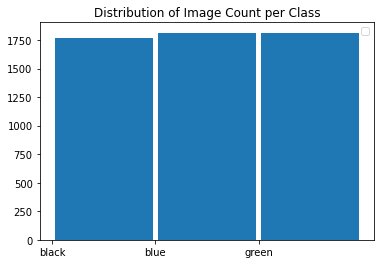

In [ ]:
black_bin_count = count_files(enel_data_path + '/Black')
blue_bin_count = count_files(enel_data_path + '/Blue')
green_bin_count = count_files(enel_data_path + '/Green')
data = [black_bin_count, blue_bin_count, green_bin_count]

plt.hist(['black', 'blue', 'green'], weights=data, bins=range(4), rwidth=.95)
plt.legend()
plt.title('Distribution of Image Count per Class')
plt.show()

### 1.2 Sample of Data

In [ ]:
def plot_images (item_dir, first=10):
  all_item_names = os.listdir(item_dir)
  item_paths = [os.path.join(item_dir,file) for file in all_item_names][:5]
  print(item_paths)

  #configure fig size
  plt.figure(figsize=(10,10))
  for index, image_path in enumerate(item_paths):
    plt.subplot(5,5,index+1)
    img = plt.imread(image_path)
    plt.tight_layout()
    plt.imshow(img,cmap='gray')

['/temp/Data/ProfsData/Black/blackProf_405.png', '/temp/Data/ProfsData/Black/blackProf_337.png', '/temp/Data/ProfsData/Black/blackProf_614.png', '/temp/Data/ProfsData/Black/blackProf_181.png', '/temp/Data/ProfsData/Black/blackProf_415.png']
['/temp/Data/ProfsData/Blue/blueProf_1160.png', '/temp/Data/ProfsData/Blue/blueProf_1023.png', '/temp/Data/ProfsData/Blue/blueProf_1591.png', '/temp/Data/ProfsData/Blue/blueProf_1665.png', '/temp/Data/ProfsData/Blue/blueProf_737.png']
['/temp/Data/ProfsData/Green/greenProf_1037.png', '/temp/Data/ProfsData/Green/greenProf_673.png', '/temp/Data/ProfsData/Green/greenProf_1433.png', '/temp/Data/ProfsData/Green/greenProf_1306.png', '/temp/Data/ProfsData/Green/greenProf_964.png']


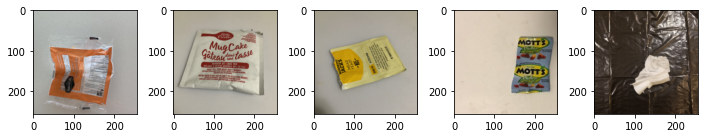

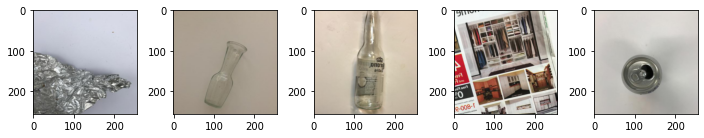

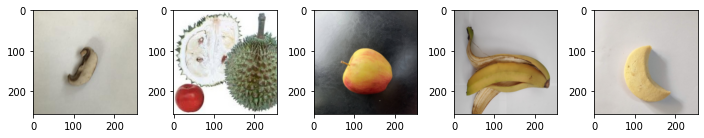

In [ ]:
plot_images(enel_data_path + '/Black')
plot_images(enel_data_path + '/Blue')
plot_images(enel_data_path + '/Green')

In [ ]:
data_names = ['OurData','KaggleData','ProfsData','Prof_Kaggle','Full']

In [ ]:
data_paths = ['/train_val_test/OurData','/train_val_test/KaggleData','/train_val_test/ProfsData','/train_val_test/Prof_Kaggle','/train_val_test/Full']

In [ ]:
def print_score(score):
  print('Loss: ', score[0], ', Accuracy: ', score[1])

## 2. Train Test Split

In [ ]:
## Train Validation Test Split
train_val_test_split(enel_data_path, '/train_val_test/ProfsData', 0.7, 0.2, 0.1)

Copying files: 5391 files [00:01, 4118.21 files/s]


## 4. Image Augmentation and Data Generators


In [ ]:
#TESTED: tested with vgg16, worked as expected
def create_generators(model_name,data_path,params_index=0,batch_size=64,seed=88):

  if model_name == 'our_cnn':
    preprocessing_function=None,
    image_size=(250,250)
  elif model_name=="efficientnetb0":
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
    image_size=(224,224)
  elif model_name=="vgg16":
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    image_size=(224,224)
  elif model_name=="resnet50":
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input
    image_size=(224,224)

  #classes
  class_names = ["Black", "Blue",  "Green"]

  #params
  params_0 = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

  params_1 = {"horizontal_flip":True,\
              "vertical_flip":True,\
             'fill_mode': 'nearest',\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
             "brightness_range":[0.9,1.1],\
             }

  params_2 = {"horizontal_flip":False,\
              "vertical_flip":False,
             }

  params_list=[params_0, params_1, params_2]           
  params=params_list[params_index]

  #image augmentation
  # image_augmentation = ImageDataGenerator(horizontal_flip=True, 
  #                        vertical_flip=True,
  #                        width_shift_range = 0.1,
  #                        height_shift_range=0.1,
  #                        rotation_range=15,
  #                        fill_mode='nearest',
  #                        brightness_range=[0.75,1.25],
  #                        zoom_range=0.25,
  #                        rescale=1.0/255,
  #                        preprocessing_function=preprocessing_function
  #                        )

  image_augmentation = ImageDataGenerator(**params,preprocessing_function=preprocessing_function)
  if model_name == 'our_cnn':
    image_augmentation = ImageDataGenerator(**params)

  #generators
  train_generator = image_augmentation.flow_from_directory(data_path+'/train',
                                                           batch_size=batch_size,
                                            target_size=image_size,
                                            class_mode='categorical',
                                            classes=class_names,
                                            shuffle=True,
                                            seed=seed,
                                            color_mode="rgb")

  validation_generator = image_augmentation.flow_from_directory(data_path+'/val',
                                                                batch_size=batch_size,
                                              target_size=image_size,
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=seed,
                                              color_mode="rgb"
                                              )

  test_generator = image_augmentation.flow_from_directory(data_path+'/test',
                                            batch_size=batch_size,
                                              target_size=image_size,
                                              class_mode='categorical',
                                            classes=class_names,
                                              shuffle=True,
                                              seed=seed,
                                            color_mode="rgb"
                                            )
  
  #step sizes
  step_size_train=train_generator.n//train_generator.batch_size
  step_size_validation =validation_generator.n//validation_generator.batch_size
  step_size_test =test_generator.n//test_generator.batch_size

  #return [(generator tuple),(size tuple)]
  return [(train_generator,validation_generator,test_generator),
          (step_size_train,step_size_validation,step_size_test)]

## 5. Callbacks

In [ ]:
def create_callbacks(model_name,patientce=5,epochs=30,lr=1e-6):
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = patientce)

  def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

  #set verbose = 0, nothing will be shown
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

  #Note: cannot save to h5 files, there will be errors, have to use directory
  path_model_it = '/checkpoints/'+model_name+'_it/'
  path_model_ft = '/checkpoints/'+model_name+'_ft/'


  monitor_it = tf.keras.callbacks.ModelCheckpoint(filepath=path_model_it, 
                                                  monitor='val_loss',
                                             verbose=0,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='min')

  monitor_ft = tf.keras.callbacks.ModelCheckpoint(filepath=path_model_ft, 
                                                  monitor='val_loss',
                                             verbose=0,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='min')

  return (early_stop,lr_schedule, monitor_it, monitor_ft, path_model_it, path_model_ft)


## 6. Plot methods

### Plot History: train and validation

In [ ]:
def plot_history(history_object, model_name = None, dataset_name = None):
  fig,axes=plt.subplots(1,2, figsize=(10,5))
  ax_accuracy = axes[0]
  ax_loss = axes[1]
  ax_accuracy.plot(history_object.history['accuracy'])
  ax_accuracy.plot(history_object.history['val_accuracy'])
  ax_accuracy.set_title('Accuracy Plot')
  ax_accuracy.legend(['Train', 'Validation'], loc='upper left')
  ax_accuracy.set(xlabel='Epochs',ylabel='Accuracy')
  ax_loss.plot(history_object.history['loss'])
  ax_loss.plot(history_object.history['val_loss'])
  ax_loss.set_title('Loss Plot')
  ax_loss.legend(['Train', 'Validation'], loc='upper right')
  ax_loss.set(xlabel='Epochs',ylabel='loss')
  
  title = 'Accuracy & Loss Plots'
  if model_name != None:
    title =  title + " of " + model_name 
    if dataset_name != None:
      title = title + ' (' + dataset_name+')'

  fig.suptitle(title, fontsize=16)
  plt.subplots_adjust(left = 0.01)

  plt.show()
  return {
      'fig':fig,
      'axes':axes
  }

### Plot Wrong Predictions

In [ ]:
# References: ENEL645 transfer_learning_imagenet
def plot_wrong_predictions(model,test_generator):
  Xtest,Ytest = test_generator.__getitem__(0)
  Ytest = Ytest.argmax(axis = 1) # get the label
  Ypred = model.predict(Xtest).argmax(axis = 1)
  wrong_indexes = np.where(Ypred != Ytest)[0]

  # Disaplying some samples from the development set
  class_names = ["Black", "Blue",  "Green"]
  sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
  plt.figure(figsize = (24,18))
  for (ii,jj) in enumerate(sample_indexes):
      plt.subplot(4,2,ii+1)
      aux = Xtest[wrong_indexes[jj]]
      aux = (aux - aux.min())/(aux.max() - aux.min())
      plt.imshow(aux, cmap = "gray")
      plt.title("Label: %s vs. Predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
  plt.show()

## 6. None Transfer Learning Process

In [ ]:
def none_transfer_learning(model_name,data_path,params_index=0,epochs=30,lr=1e-4):
  model = None

  class_names = ["Black", "Blue",  "Green"]

  #choose model
  #References: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0
  #References: https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16
  if(model_name.lower()=="our_cnn"):
    model = our_cnn()
  elif(model_name.lower()=="efficientnetb0"):
    model = tf.keras.applications.EfficientNetB0(classes = len(class_names),
                                                 include_top=True,
                                        weights=None)
    model.trainable=True;
  elif(model_name.lower()=="vgg16"):
    model = tf.keras.applications.VGG16(classes = len(class_names),
                                        include_top=True,
                                        weights=None)
    model.trainable=True
  elif(model_name.lower()=="resnet50"):
    model = tf.keras.applications.ResNet50(classes = len(class_names),
                                        include_top=True,
                                        weights=None)
    model.trainable=True
    
  generators = create_generators(model_name,data_path)
  callbacks=create_callbacks(model_name)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  history = model.fit(generators[0][0], 
                         epochs=epochs, 
                         verbose = 1, 
                       callbacks= [callbacks[0],callbacks[1]], 
                       validation_data = generators[0][1])
  
  test_score = model.evaluate(generators[0][2])  

  return {
      "model":model,
      "model_name":model_name,
      "epochs":epochs,
      "lr":lr,
      "history":history,
      "test_score":test_score,
      "generators": generators,
      "callbacks": callbacks
  }

## 6. Transfer Learning Processes - All In One

In [ ]:
def transfer_learning(model_name,data_path,params_index=0,epochs=30,lr=1e-4):
  base_model = None

  #choose model
  if(model_name=="none"):
    return "Invalid model"
  elif(model_name=="efficientnetb0"):
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet',  # Load base model with ImageNet weights
        input_shape=(224, 224, 3),
        include_top=False)
  elif(model_name=="vgg16"):
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',  # Load base model with ImageNet weights
        input_shape=(224, 224, 3),
        include_top=False)
    
  #classes
  class_names = ["Black", "Blue",  "Green"]

  #disable training
  base_model.trainable=False

  #Adding layers
  l1 = base_model(base_model.input, training = False)
  l2 = tf.keras.layers.Flatten()(l1)

  out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(l2)
  model = tf.keras.Model(inputs = base_model.input, outputs = out)

  #complie model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  #create data generators
  generators = create_generators(model_name,data_path)

  #create callbacks
  callbacks = create_callbacks(model_name,5,epochs)

  #intial train model
  history_it = model.fit(generators[0][0], #train generator
                         epochs=10, #hard coded to be 5
                         verbose = 0, 
                       callbacks= [callbacks[0],callbacks[1],callbacks[2]], 
                       validation_data = generators[0][1])
  
  #fine tuning
  print("#1")
  model = tf.keras.models.load_model(callbacks[4])
  model.trainable = True

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  history_ft = model.fit(generators[0][0], 
                         epochs=epochs-10, 
                         verbose = 0, 
                       callbacks= [callbacks[0],callbacks[1],callbacks[3]], 
                       validation_data = generators[0][1])

  model = tf.keras.models.load_model(callbacks[4])
  score_it = model.evaluate(generators[0][2])

  model = tf.keras.models.load_model(callbacks[5])
  score_ft = model.evaluate(generators[0][2])

  #return (history_it,history_ft,score_it,score_ft)
  return {
      'history_it':history_it,
      'history_ft':history_ft,
      'score_it': score_it,
      'score_ft':score_ft,
      'model':model,
      'model_name':model_name,
      'generators':generators,
      'callbacks':callbacks
  }



In [ ]:
print('Run everything before')

Run everything before


# Best Model Selection

## None Transfer Learning

### Our CNN Model

In [ ]:
our_cnn_results = none_transfer_learning('our_cnn',data_paths[2])

Found 3772 images belonging to 3 classes.
Found 1077 images belonging to 3 classes.
Found 542 images belonging to 3 classes.
Epoch 1/30
59/59 [==============================] - 74s 1s/step - loss: 1.0397 - accuracy: 0.4316 - val_loss: 0.9506 - val_accuracy: 0.5125 - lr: 1.0000e-04
Epoch 2/30
59/59 [==============================] - 71s 1s/step - loss: 0.9221 - accuracy: 0.5331 - val_loss: 0.9063 - val_accuracy: 0.5562 - lr: 1.0000e-04
Epoch 3/30
59/59 [==============================] - 71s 1s/step - loss: 0.8920 - accuracy: 0.5689 - val_loss: 0.9115 - val_accuracy: 0.5348 - lr: 1.0000e-04
Epoch 4/30
59/59 [==============================] - 71s 1s/step - loss: 0.8860 - accuracy: 0.5679 - val_loss: 0.8824 - val_accuracy: 0.5933 - lr: 1.0000e-04
Epoch 5/30
59/59 [==============================] - 70s 1s/step - loss: 0.8432 - accuracy: 0.5994 - val_loss: 0.8501 - val_accuracy: 0.6054 - lr: 1.0000e-04
Epoch 6/30
59/59 [==============================] - 70s 1s/step - loss: 0.8150 - accuracy:

In [ ]:
print_score(our_cnn_results.get('test_score'))

Loss:  0.6273549795150757 , Accuracy:  0.7029520273208618


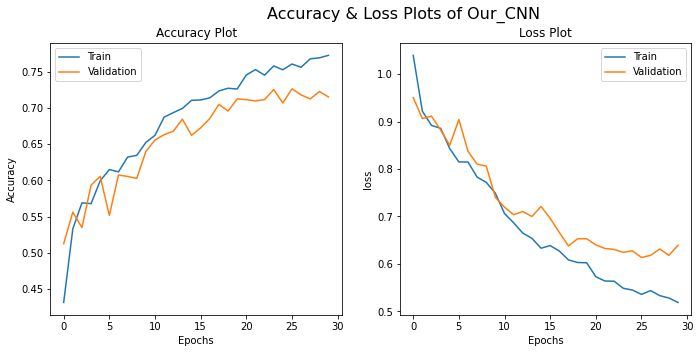

{'axes': array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe853a31d50>,
       dtype=object), 'fig': <Figure size 720x360 with 2 Axes>}

In [ ]:
plot_history(our_cnn_results.get('history'),'Our_CNN')

### VGG16 Without Imagenet Weights

In [ ]:
vgg16_ntl_results = none_transfer_learning('vgg16',data_paths[2])

Found 3772 images belonging to 3 classes.
Found 1077 images belonging to 3 classes.
Found 542 images belonging to 3 classes.
Epoch 1/30
59/59 [==============================] - 72s 1s/step - loss: 1.0405 - accuracy: 0.4796 - val_loss: 0.9188 - val_accuracy: 0.5487 - lr: 1.0000e-04
Epoch 2/30
59/59 [==============================] - 63s 1s/step - loss: 0.8903 - accuracy: 0.5612 - val_loss: 0.8682 - val_accuracy: 0.5859 - lr: 1.0000e-04
Epoch 3/30
59/59 [==============================] - 62s 1s/step - loss: 0.8683 - accuracy: 0.5761 - val_loss: 0.8749 - val_accuracy: 0.5515 - lr: 1.0000e-04
Epoch 4/30
59/59 [==============================] - 62s 1s/step - loss: 0.8244 - accuracy: 0.5965 - val_loss: 0.8288 - val_accuracy: 0.5970 - lr: 1.0000e-04
Epoch 5/30
59/59 [==============================] - 62s 1s/step - loss: 0.7837 - accuracy: 0.6148 - val_loss: 0.7785 - val_accuracy: 0.6295 - lr: 1.0000e-04
Epoch 6/30
59/59 [==============================] - 62s 1s/step - loss: 0.7637 - accuracy:

In [ ]:
print_score(vgg16_ntl_results.get('test_score'))

Loss:  0.6563591361045837 , Accuracy:  0.7306272983551025


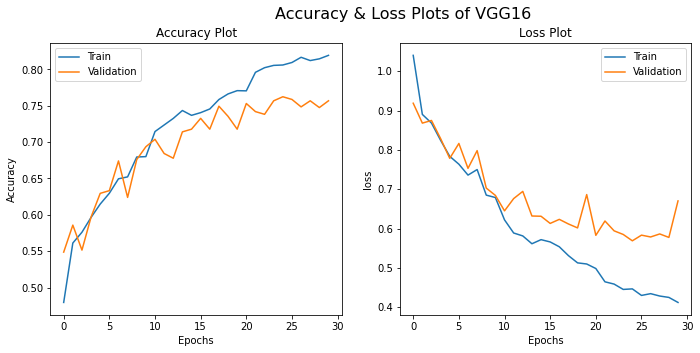

{'axes': array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe85652fb50>,
       dtype=object), 'fig': <Figure size 720x360 with 2 Axes>}

In [ ]:
plot_history(vgg16_ntl_results.get('history'),'VGG16')

### EfficientnetB0 Without Imagenet Weights



In [ ]:
efficientnetb0_ntl_results = none_transfer_learning('efficientnetb0',data_paths[2])

Found 3772 images belonging to 3 classes.
Found 1077 images belonging to 3 classes.
Found 542 images belonging to 3 classes.
Epoch 1/30
59/59 [==============================] - 75s 1s/step - loss: 1.7962 - accuracy: 0.3680 - val_loss: 1.1572 - val_accuracy: 0.3278 - lr: 1.0000e-04
Epoch 2/30
59/59 [==============================] - 62s 1s/step - loss: 1.6345 - accuracy: 0.4043 - val_loss: 1.1115 - val_accuracy: 0.3361 - lr: 1.0000e-04
Epoch 3/30
59/59 [==============================] - 61s 1s/step - loss: 1.4202 - accuracy: 0.4470 - val_loss: 1.1441 - val_accuracy: 0.3278 - lr: 1.0000e-04
Epoch 4/30
59/59 [==============================] - 61s 1s/step - loss: 1.3422 - accuracy: 0.4661 - val_loss: 1.1334 - val_accuracy: 0.3361 - lr: 1.0000e-04
Epoch 5/30
59/59 [==============================] - 61s 1s/step - loss: 1.2688 - accuracy: 0.4920 - val_loss: 1.2454 - val_accuracy: 0.3361 - lr: 1.0000e-04
Epoch 6/30
59/59 [==============================] - 61s 1s/step - loss: 1.2145 - accuracy:

In [ ]:
print_score(efficientnetb0_ntl_results.get('test_score'))

Loss:  0.9094336628913879 , Accuracy:  0.61623615026474


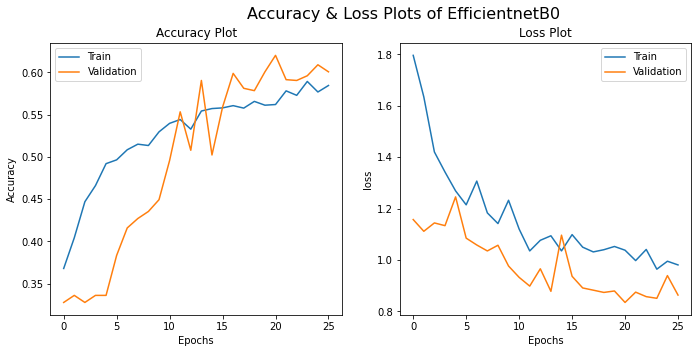

{'axes': array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8564fd4d0>,
       dtype=object), 'fig': <Figure size 720x360 with 2 Axes>}

In [ ]:
plot_history(efficientnetb0_ntl_results.get('history'),'EfficientnetB0')

## Transfer Learning

### VGG16 - Transfer Learning

In [ ]:
vgg16_tl_results = transfer_learning('vgg16',data_paths[2],0,30)

Found 3772 images belonging to 3 classes.
Found 1077 images belonging to 3 classes.
Found 542 images belonging to 3 classes.
INFO:tensorflow:Assets written to: /checkpoints/vgg16_it/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_it/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_it/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_it/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_it/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_it/assets
#1
INFO:tensorflow:Assets written to: /checkpoints/vgg16_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/vgg16_ft/assets
9/9 [==============================] - 7s 746ms/step - loss: 1.7595 - accuracy: 0.7491


In [ ]:
print_score(vgg16_tl_results.get('score_it'))

Loss:  1.8707975149154663 , Accuracy:  0.7712177038192749


In [ ]:
print_score(vgg16_tl_results.get('score_ft'))

Loss:  1.7595245838165283 , Accuracy:  0.7490774989128113


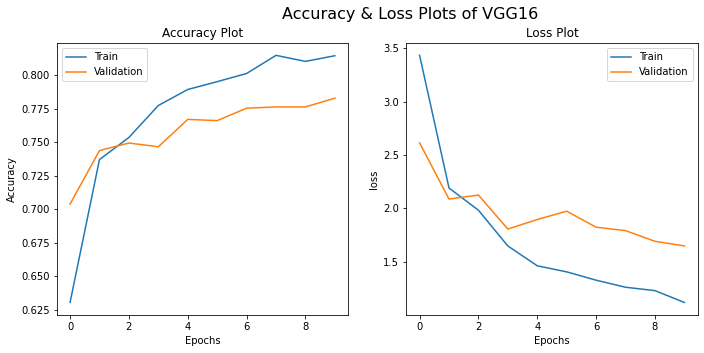

{'axes': array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8524f4490>,
       dtype=object), 'fig': <Figure size 720x360 with 2 Axes>}

In [ ]:
plot_history(vgg16_tl_results.get('history_it'),'VGG16')

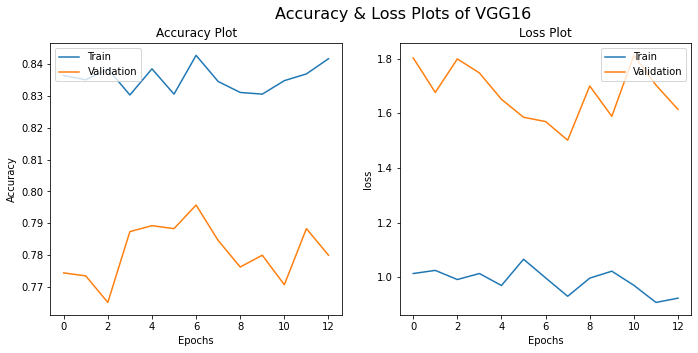

{'axes': array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe854f13a50>,
       dtype=object), 'fig': <Figure size 720x360 with 2 Axes>}

In [ ]:
plot_history(vgg16_tl_results.get('history_ft'),'VGG16')

### EfficientnetB0 - Transfer Learning

In [ ]:
efficientnetb0_tl_results = transfer_learning('efficientnetb0',data_paths[2],0,30)

16719872/16705208 [==============================] - 0s 0us/step
Found 3772 images belonging to 3 classes.
Found 1077 images belonging to 3 classes.
Found 542 images belonging to 3 classes.
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
#1
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets
9/9 [==============================] - 8s 745ms/step - loss: 0.5380 - accuracy: 0.8192


In [ ]:
print_score(efficientnetb0_tl_results.get('score_it'))

Loss:  0.48679330945014954 , Accuracy:  0.8173431754112244


In [ ]:
print_score(efficientnetb0_tl_results.get('score_ft'))

Loss:  0.5379849076271057 , Accuracy:  0.8191881775856018


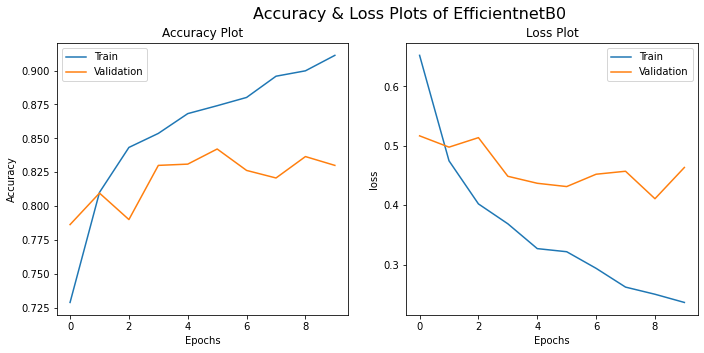

{'axes': array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe853a74a50>,
       dtype=object), 'fig': <Figure size 720x360 with 2 Axes>}

In [ ]:
plot_history(efficientnetb0_tl_results.get('history_it'),'EfficientnetB0')

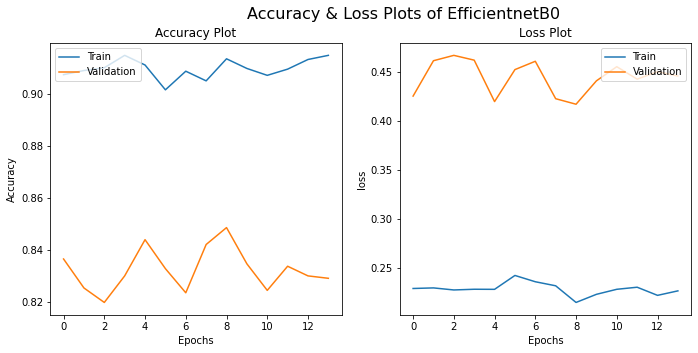

{'axes': array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe425531790>,
       dtype=object), 'fig': <Figure size 720x360 with 2 Axes>}

In [ ]:
plot_history(efficientnetb0_tl_results.get('history_ft'),'EfficientnetB0')

# Train the best model with different data

## Prepare the unused data

In [ ]:
# train, val, test split
train_val_test_split('/temp/Data/OurData', '/train_val_test/OurData', 0.7, 0.2, 0.1)
train_val_test_split('/temp/Data/KaggleData', '/train_val_test/KaggleData', 0.7, 0.2, 0.1)
train_val_test_split('/temp/Data/Prof_Kaggle', '/train_val_test/Prof_Kaggle', 0.7, 0.2, 0.1)
train_val_test_split('/temp/Data/Full', '/train_val_test/Full', 0.7, 0.2, 0.1)

Copying files: 300 files [00:00, 3354.96 files/s]
Copying files: 1935 files [00:00, 5838.80 files/s]
Copying files: 7326 files [00:01, 4519.59 files/s]
Copying files: 7626 files [00:01, 4305.77 files/s]


## Train the best model

In [ ]:
best_model_results = []

In [ ]:
for data_path in data_paths:
  best_model_results.append(transfer_learning('efficientnetb0',data_path,0,100))

Found 210 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#1
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1/1 [==============================] - 2s 2s/step - loss: 0.3842 - accuracy: 0.8000
Found 1353 images belonging to 3 classes.
Found 385 images belonging to 3 classes.
Found 197 images belonging to 3 classes.
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets
#1
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets
4/4 [==============================] - 4s 538ms/step - loss: 0.1159 - accuracy: 0.9340
Found 3772 images belonging to 3 classes.
Fou

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_it/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#1
INFO:tensorflow:Assets written to: /checkpoints/efficientnetb0_ft/assets


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


12/12 [==============================] - 11s 793ms/step - loss: 0.4162 - accuracy: 0.8366


In [ ]:
data_names

['OurData', 'KaggleData', 'ProfsData', 'Prof_Kaggle', 'Full']

In [ ]:
data_paths

['/train_val_test/OurData',
 '/train_val_test/KaggleData',
 '/train_val_test/ProfsData',
 '/train_val_test/Prof_Kaggle',
 '/train_val_test/Full']

In [ ]:
for result in best_model_results:
  print(result.get('score_it'))
  print(result.get('score_ft'))

[0.32817429304122925, 0.8999999761581421]
[0.3841724991798401, 0.800000011920929]
[0.08758938312530518, 0.9644669890403748]
[0.11586014926433563, 0.9340101480484009]
[0.5345977544784546, 0.7933579087257385]
[0.5538039803504944, 0.7970479726791382]
[0.40538695454597473, 0.8517006635665894]
[0.38966870307922363, 0.8639456033706665]
[0.3934115469455719, 0.8509804010391235]
[0.4162237346172333, 0.8366013169288635]


In [ ]:
for result, data_path in zip(best_model_results, data_paths):
  print('Data: ', data_path)
  print('Score_it: ')
  print_score(result.get('score_it'))
  print('Score_ft: ')
  print_score(result.get('score_ft'))

Data:  /train_val_test/OurData
Score_it: 
Loss:  0.32817429304122925 , Accuracy:  0.8999999761581421
Score_ft: 
Loss:  0.3841724991798401 , Accuracy:  0.800000011920929
Data:  /train_val_test/KaggleData
Score_it: 
Loss:  0.08758938312530518 , Accuracy:  0.9644669890403748
Score_ft: 
Loss:  0.11586014926433563 , Accuracy:  0.9340101480484009
Data:  /train_val_test/ProfsData
Score_it: 
Loss:  0.5345977544784546 , Accuracy:  0.7933579087257385
Score_ft: 
Loss:  0.5538039803504944 , Accuracy:  0.7970479726791382
Data:  /train_val_test/Prof_Kaggle
Score_it: 
Loss:  0.40538695454597473 , Accuracy:  0.8517006635665894
Score_ft: 
Loss:  0.38966870307922363 , Accuracy:  0.8639456033706665
Data:  /train_val_test/Full
Score_it: 
Loss:  0.3934115469455719 , Accuracy:  0.8509804010391235
Score_ft: 
Loss:  0.4162237346172333 , Accuracy:  0.8366013169288635


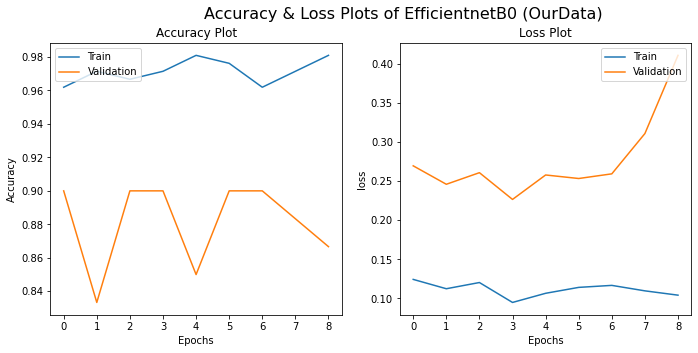

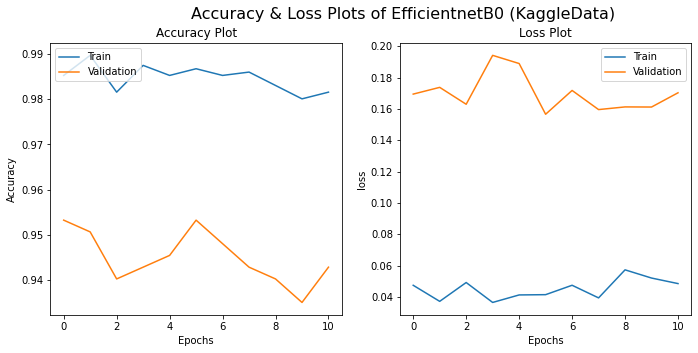

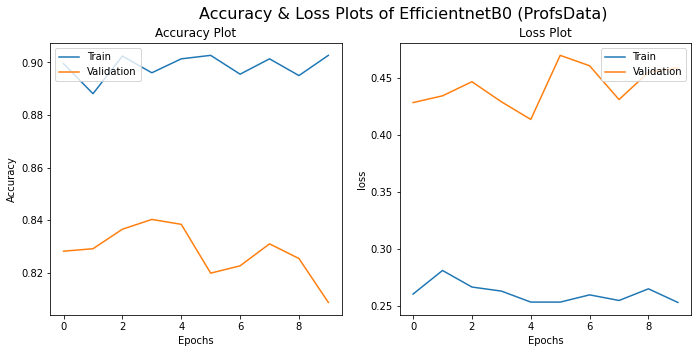

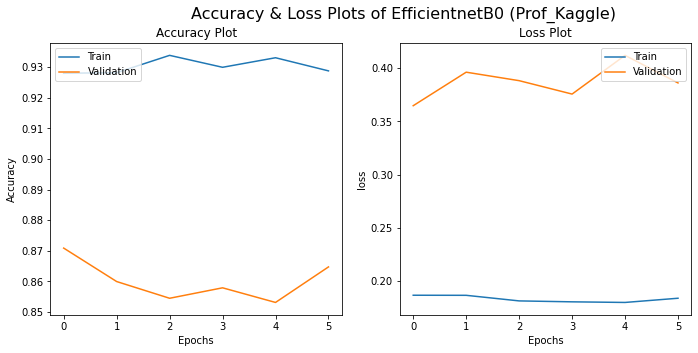

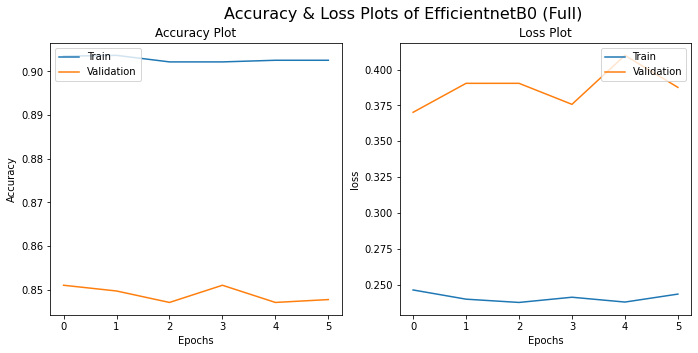

In [ ]:
for result, data_name in zip(best_model_results,data_names):
  plot_history(result.get('history_ft'),'EfficientnetB0', data_name)

Data:  /train_val_test/Full


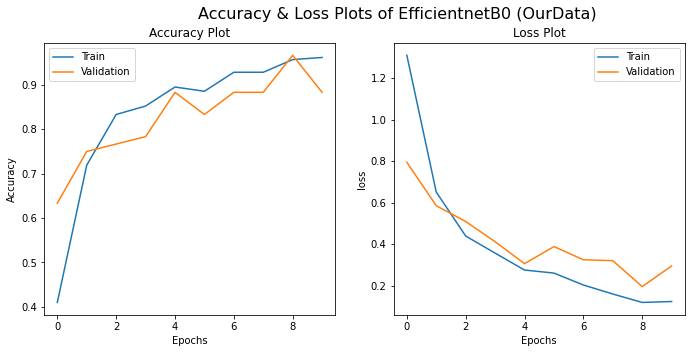

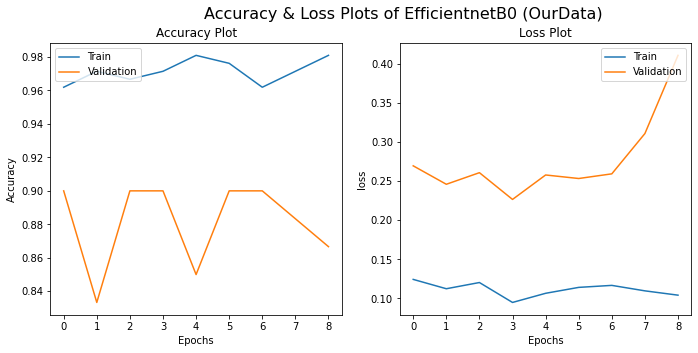

Data:  /train_val_test/Full


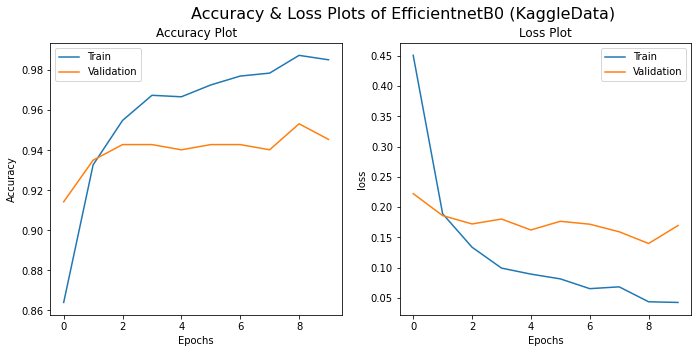

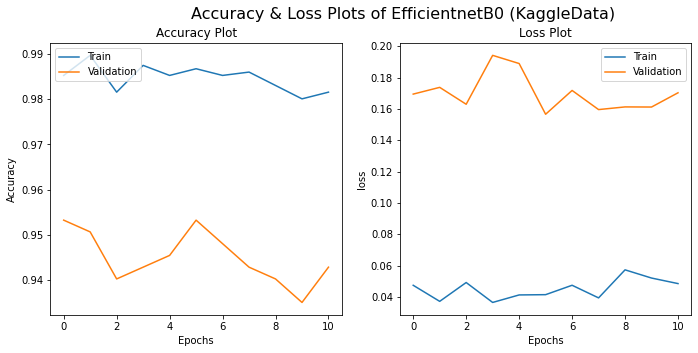

Data:  /train_val_test/Full


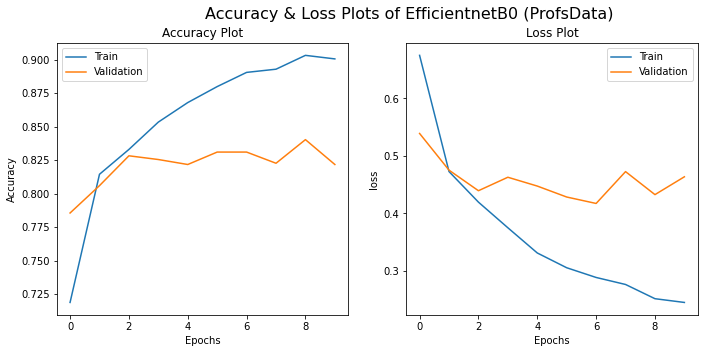

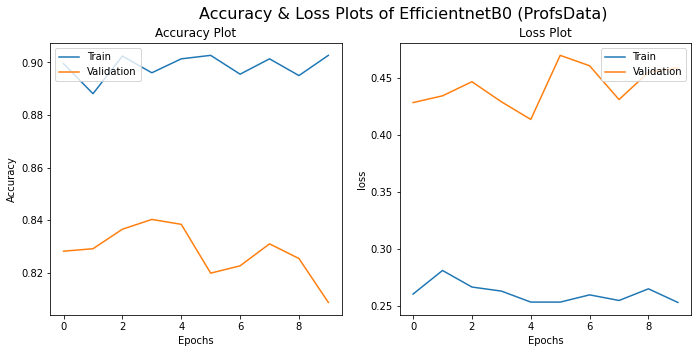

Data:  /train_val_test/Full


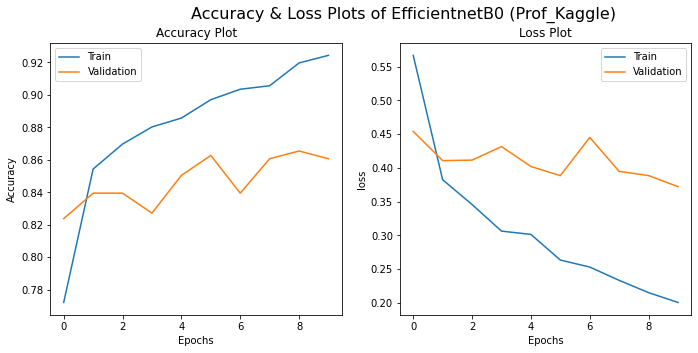

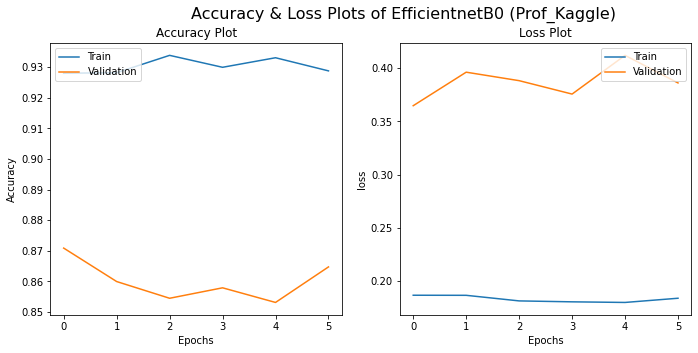

Data:  /train_val_test/Full


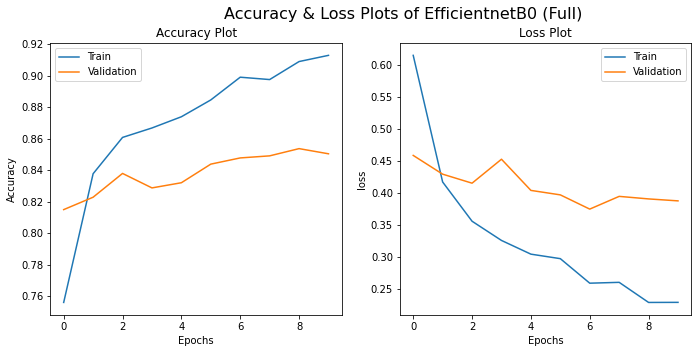

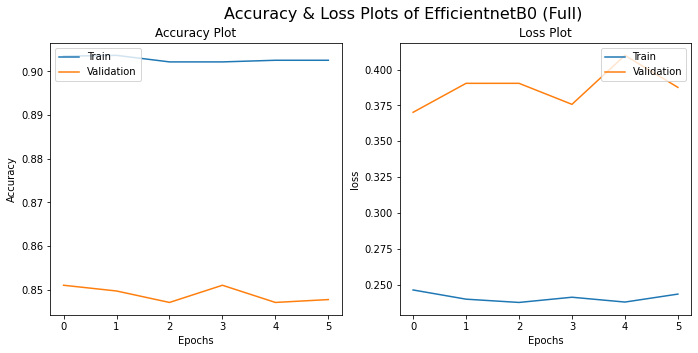

In [ ]:
for result, data_name in zip(best_model_results,data_names):
  print("Data: ", data_path)
  plot_history(result.get('history_it'),'EfficientnetB0', data_name)
  plot_history(result.get('history_ft'),'EfficientnetB0', data_name)

In [ ]:
for result, data_name in zip(best_model_results,data_names):
  print("Data: ", data_name)
  plot_wrong_predictions(result.get('model'),result.get('generators')[0][2])

Data:  OurData


ValueError: ignored